In [27]:
#| output: false
#| echo: false

%load_ext pycodestyle_magic
%pycodestyle_on

1:1: E265 block comment should start with '# '
2:1: E265 block comment should start with '# '
3:1: E265 block comment should start with '# '


To host an open water swim meet in the canals of Amsterdam, we must first ensure that the water quality is good enough for swimming. (//TODO citation)
Unfortunately, only official bathing sites in the Amsterdam canals are monitored for water quality.
Thus, there is limited data available.


We do know that there are various factors that affect the quality of water, such as sewage overflows, water currents, temperature and more. (//TODO citation needed)
If we had data sampled at appropriate locations and sufficient background knowledge, we would use a model to estimate water pollution levels and how they are affected by weather and canal traffic.
For now, we will use the available data for some basic analysis.

## Datasets found

Here is the list of **datasets** we have identified with regards to water pollution levels, along with the **relevant available sources** (if existant) of information and their **formats**.

| # | Parameter | Explanation | Source | Format|
|:--|:----------|:------------|:-------|:------|
|1. | Pollution levels in Herensgracht and Prinsengracht | Chemical composition of the water | [Study](https://www.rivm.nl/publicaties/microbiologische-kwaliteit-van-grachtenwater-in-amsterdam) | Journal |
|2. | Pollution levels in swimming locations | Chemical levels in swimming locations in 2019 with interpreted data | [Dataset](https://onderzoek.amsterdam.nl/dataset/water-in-amsterdam) | Excel |
|3. | Places with sensors available. | &nbsp;| &nbsp; | &nbsp; |
|4. |Historical data for water quality. | &nbsp; | &nbsp; | &nbsp; |
|5. |Sewage overflows |  Used Python script to convert file to Geojson. CRS = EPSG 28992 | [Dataset](https://data.overheid.nl/dataset/xnhveaeyheww2w#panel-resources) | JSON
|6. |Canal traffic | ??? | ??? | ???
: {tbl-colwidths="[5,20,40,15,10]"}

### Sewage overflows

Since Amsterdam uses a combined sewage system, sewage overflows are a major source of water pollution after heavy rain. [@leemans_wu_2017]
We can see if there areas without sewage overflow points in the canals.

The Waternet sewerage network data is available on [Overheid.nl](https://data.overheid.nl/dataset/xnhveaeyheww2w).
Unfortunately, the download link for the WFS data returned a 404 error.
Instead, we used the provided API to retrieve the sewage nodes, then saved it to [sewer_nodes.geojson](./data/sewer_nodes.geojson). 
(Coordinate Reference System used is EPSG:7415.)
We then filtered the data to get the sewage overflow nodes and saved it to [sewage_overflow_nodes.geojson](./data/sewage_overflow_nodes.geojson).

In [56]:
from urllib.request import urlopen
import json
import os.path
import geopandas as gpd
from pyproj import Transformer

FILENAME_SEWER_NODES = "data/sewer_nodes.geojson"
FILENAME_SEWAGE_OVERFLOW_NODES = "data/sewage_overflow_nodes.geojson"
URL_SEWER_NODES = ("https://api.data.amsterdam.nl/v1/leidingeninfrastructuur/"
                   "waternet_rioolknopen/?page_size=1000")
SEWAGE_OVERFLOW_TYPES = [
    "Uitlaat gemengde overstort",  # Mixed overflow
    "Uitlaat vuilwater nooduitlaat",  # Black water emergency outlet
    "(Externe) overstortput",  # (External) overflow
    "Overstort met signalering",  # Overflow with signaling
    "Interne overstortput",  # Internal overflow
    "Nooduitlaat met signalering"  # Emergency overflow with signaling
]


def get_sewer_nodes(url, geojson_filename, is_test_run=False):
    """Return sewer nodes as geodataframe, read from the GeoJSON file.
    If file does not exist, retrieve the data from the API and save results to
    the GeoJSON file. If this is a test run and the API is called, only partial
    results will be retrieved from the API.

    Parameters:
        url: API endpoint for sewage networks data
        geojson_filename: file containing (or will contain) the saved data
        is_test_run: if True, limit number of API requests made (for debugging)
    """

    if os.path.exists(geojson_filename):
        print("Sewer nodes data has already been parsed to GeoJSON in '{}'"
              .format(geojson_filename))
        gdf = gpd.read_file(geojson_filename)
    else:
        print(("Sewer nodes GeoJSON file does not exist. "
               "Requesting data from API{}").format(url))
        geojson_data = retrieve_sewer_nodes_data_from_api(url, is_test_run)

        # Save data for future use
        with open(geojson_filename, "a+", encoding='utf-8') as outfile:
            json.dump(geojson_data, outfile)
        print("Sewer nodes data saved to file '{}'".format(geojson_filename))

        gdf = gpd.GeoDataFrame.from_features(geojson_data['features'])
    return gdf


def retrieve_sewer_nodes_data_from_api(url, is_test_run=False):
    """Return sewer nodes data as GeoJSON.
    In test runs, limit the number of API requests made."""

    data_entries = request_sewer_nodes_data_from_api(url, is_test_run)
    geojson_data = parse_sewer_node_results(data_entries)

    return geojson_data


def request_sewer_nodes_data_from_api(url, is_test_run=False):
    """Retrieve all sewer node results from API.
    For test runs, stop after first 3 pages of results."""

    api_response = json.load(urlopen(url))

    sewer_node_entries = []
    num_pages_requested = 0

    while api_response is not None:
        data = api_response["_embedded"]["waternet_rioolknopen"]
        sewer_node_entries += data

        if "next" in api_response["_links"]:  # has next page of results
            api_response = json.load(
                urlopen(api_response["_links"]["next"]["href"]))
        else:  # is last page of results
            api_response = None

        num_pages_requested += 1

        if is_test_run and num_pages_requested >= 3:
            break

    return sewer_node_entries


def parse_sewer_node_results(sewer_node_entries):
    """Parse sewer node results from Amsterdam sewer network API to GeoJSON"""

    transformer = Transformer.from_crs("EPSG:7415", "EPSG:4326")

    geojson = {
        "type": "FeatureCollection",
        "features": []
    }

    for entry in sewer_node_entries:
        x, y, z = entry["geometrie"]["coordinates"]
        lat, lon = transformer.transform(x, y)
        feature = {
            "type": "Feature",
            "geometry": {
                "type": "Point",
                "coordinates": [lon, lat]
            },
            "properties": {
                "id": entry["id"],
                "typeKnoop": entry["typeKnoop"]
            }
        }
        geojson["features"].append(feature)

    return geojson


def get_sewage_overflow_nodes(url,
                              sewer_nodes_filename,
                              sewage_overflow_nodes_filename,
                              is_test_run):
    """Return sewage overflow points as geodataframe read from the
    GeoJSON file. If file does not exist, get and process the sewer nodes data,
     then save results to the GeoJSON file.

    Parameters:
        url: API endpoint for sewage networks data
        sewer_nodes_filename: name of GeoJSON file containing (or will contain)
                              the saved sewer nodes data
        sewage_overflow_nodes_filename: name of GeoJSON file containing
                                        (or that will contain) the saved
                                        sewage overflow nodes data
        is_test_run: if True, limit number of API requests made (for debugging)
    """

    if os.path.exists(sewage_overflow_nodes_filename):
        print("Sewage overflow nodes data already exists in file '{}'"
              .format(sewage_overflow_nodes_filename))
        gdf_overflows = gpd.read_file(sewage_overflow_nodes_filename)
    else:
        gdf_sewer_nodes = get_sewer_nodes(url, sewer_nodes_filename,
                                          is_test_run)
        gdf_overflows = gdf_sewer_nodes[gdf_sewer_nodes["typeKnoop"]
                                        .isin(SEWAGE_OVERFLOW_TYPES)]
        gdf_overflows.to_file(sewage_overflow_nodes_filename)
        print("Sewage overflow nodes data saved to file '{}'"
              .format(sewage_overflow_nodes_filename))
    return gdf_overflows


gdf_overflows = get_sewage_overflow_nodes(
    URL_SEWER_NODES, FILENAME_SEWER_NODES, FILENAME_SEWAGE_OVERFLOW_NODES,
    is_test_run=True
)

We then plot the sewage overflow points on a map.


In [57]:
# pip install folium matplotlib mapclassify

import folium

map_of_sewage_overflow_nodes = gdf_overflows.explore(
    legend=True,  # show legend
    name="Sewage Overflow Points",
)


folium.TileLayer("CartoDB positron", show=False).add_to(
    map_of_sewage_overflow_nodes
)

map_of_sewage_overflow_nodes

Observe that there are fewer sewage overflow points in the northeast area of Amsterdam's canals, near Marineterrein.
Assuming water pollution dissipates quickly with distance from the sewage overflow point, we can choose a route that avoids most of the sewer nodes to ensure better water quality for the swim.

### Canal Traffic


Boat traffic is another source of water pollution.
Due to the lack of exhaust gas treatment systems in boat engines, as found in all modern car engines, a modern 5 horsepower 4-stroke outboard engine can be as polluting as 39 passenger cars driving at 95 km/h. [@propel_why_2022]
As of 2020, there are about 12 550 boats in the canals of Amsterdam, approximately 550 of which are commercial boats, the remaining 12000 are recreational boats. 
Of the commercial fleet about 75% is emission free, while for recreational boats this percentage is only 5%. [@sterling_amsterdams_2020]

While we do not know the detailed relationship between boat traffic and water quality, we do know that water toxicity as a result of fossil fuelled boats can stay present up to 14 days after the use of boats [@JUTTNER19951976].
Thus, one possibility is to limit the number of fossil fuelled boats in the two weeks prior to the event.

## Choosing a route

Since the Amsterdam City Swim is held annually in the canals, this suggests that an open water swim is feasible.
However, we will need to find a suitable 5km route.
We have been told to ensure that the event does not impact commercial water transport, and has a small impact on the canal boat routes.


### Canal traffic

To minimise impact on boat routes, we look for a route that avoids areas of high canal traffic.
This would also result in a route with cleaner water.

Waternet commissioned TNO to produce a model to predict traffic densities in the canal. [@snelder_op_2013] The prediction results from the model are as follows (image only, as we do not have access to the raw data):

![image](images/Ams%20Canal%20Speeds-Layout1-06.jpg)

//TODO commercial routes and canal boat routes

### Amsterdam City Swim

We take reference from the Amsterdam City Swim, which is held every summer in the canals of Amsterdam.
We have the routes for 2019 and 2023, both of which are the same, other than the direction.

![Amsterdam City Swim 2019 route](images/Ams%20Canal%20Speeds-Layout1-09.jpg)

![Amsterdam City Swim 2023 route](images/Ams%20Canal%20Speeds-Layout1-11.jpg)

![Amsterdam City Swim 2019 & 2023 routes](images/Ams%20Canal%20Speeds-Layout1-12.jpg)


### Identifying potential routes

Based on the City Swims, Amsterdam Oost seems to be a suitable area for open water swimming events.
Visual comparison also shows that Amsterdam Oost has relatively fewer sewage overflow points and less canal traffic.

![Amsterdam Oost](images/Ams%20Canal%20Speeds-Layout1-13.jpg)



Thus, we have identified 3 potential 5km routes in this area, indicated in the images below.
Our recommendation is the third route, as it traverses the fewest number of sewage overflow points.

![Route 1](images/Ams%20Canal%20Speeds-Layout1-14.jpg)

![Route 2](images/Ams%20Canal%20Speeds-Layout1-15.jpg)

![Route 3](images/Ams%20Canal%20Speeds-Layout1-16.jpg)


## Recommendations

We propose the following route, which traverses the fewest number of sewage overflow nodes and avoids areas with high traffic.

![Route 3](images/Ams%20Canal%20Speeds-Layout1-16.jpg)

However, since Waternet recommends people to avoid swimming in the waters for 3 days after heavy rainfall [@waternet_swimming_nodate], we would recommend finding an alternative backup route in case there is heavy rainfall prior to the event.
It would also be better for water quality should fossil fuelled boats be banned from the area for two weeks before the event, though this may not be economically feasible.

### Appendix: automated route finding

For comparison purposes, we wrote a script to automatically identify potential routes for the swim.

//TODO

C:\Users\ky\AppData\Local\Temp\ipykernel_17984\635619972.py:4: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  ox.config(log_console=True, use_cache=True,


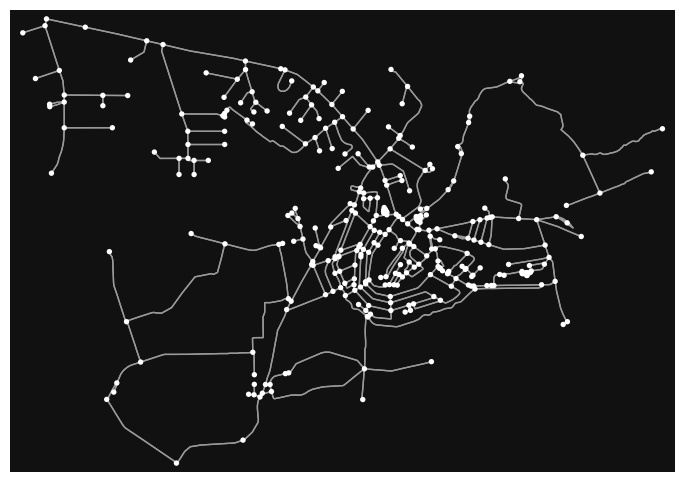

(<Figure size 1200x600 with 1 Axes>, <Axes: >)

In [3]:
import osmnx as ox
import networkx as nx

ox.config(log_console=True, use_cache=True,
          useful_tags_way = ox.settings.useful_tags_way + ['canal'])
amsterdam_canals = ox.graph_from_place('Amsterdam, Netherlands', custom_filter='["waterway"="canal"]')
# matlplot lib is used, sizes go in inches...
ox.plot_graph(amsterdam_canals, figsize=(12,6))

In [4]:
ox.graph_to_gdfs(amsterdam_canals, nodes=False).explore()


In [5]:
# amsterdam_waterways = ox.graph_from_place('Amsterdam, Netherlands', custom_filter='["waterway"]')
amsterdam_waterways = ox.graph_from_place('Amsterdam, Netherlands', custom_filter='["waterway"~"canal|river"]')
# matlplot lib is used, sizes go in inches...
ox.graph_to_gdfs(amsterdam_waterways, nodes=False).explore()

In [6]:
import numpy as np
# waterway_types = list(ox.graph_to_gdfs(amsterdam_waterways)[1]['waterway'])
# waterway_types

# H = nx.Graph(((u, v, e) for u,v,e in G.edges(data=True) if e['since'] == 'December 2008'))
# nx.draw(H,with_labels=True,node_size=3000)
# plt.show()

for u, v, e in amsterdam_waterways.edges(data=True):
    print(u, v, e['waterway'])

KeyError: 'waterway'

In [ ]:
def find_routes_of_length(start_node, graph, route_length):
       
    def find_routes_containing_path(curr_node, curr_path, curr_length, graph):
        if curr_length > route_length: # found valid path
            # print("Found path:", curr_length, curr_path)
            return [curr_path]
        
        traversed_nodes = [edge[0] for edge in curr_path] + [curr_node]
        prev_node = curr_path[-1][0] if len(curr_path) > 0 else None
        incident_edges = graph.edges(curr_node, keys=True)
        routes_containing_curr_path = []
        # print("Prev node", prev_node, "Curr node", curr_node)
        for edge in incident_edges:
            if edge in curr_path or traversed_nodes.count(edge[1]) >= 1 or edge[1] == prev_node:
                continue
            new_path = curr_path + [edge]
            # print(edge, amsterdam_waterways.edges[edge])
            edge_length = amsterdam_waterways.edges[edge]["length"]
            routes_containing_new_path = find_routes_containing_path(edge[1], new_path, curr_length + edge_length, graph)
            routes_containing_curr_path.extend(routes_containing_new_path)
            # print(edge_length, new_path)
        
        return routes_containing_curr_path
    
    return find_routes_containing_path(start_node, [], 0, graph)



In [ ]:
# Use Marineterrein pool as start point        
lat, lon = 52.37343358243731, 4.916215248650945
start_node = ox.distance.nearest_nodes(amsterdam_waterways, lon, lat, return_dist=False)

routes = find_routes_of_length(start_node, amsterdam_waterways, 5000)
print("Found {} routes.".format(len(routes)))

# 252142901, 331854233, 0),
#  (331854233, 252142901, 0),
#  (252142901, 324827507, 0),
#  (324827507, 305155548, 0),
#  (305155548, 324827507, 0),
#  (324827507, 252142901, 0),
#  (252142901, 8010136114, 0)]

In [ ]:
# nx.draw_networkx_edges(amsterdam_waterways,edgelist=routes[0])
# ox.plot_graph_route(amsterdam_waterways, [x for (x, y, k) in routes[0]])
def get_route_from_edge_list(edges):
    return [x for (x, y, k) in routes[0]]
# route1 = [x for (x, y, k) in routes[0]]

# for edge_list in routes[0:1]:
# edge_list = routes[5]
# route = get_route_from_edge_list(edge_list)
# route_edges = ox.utils_graph.route_to_gdf(amsterdam_waterways, route)
# route_edges.explore(tiles="cartodbpositron", style_kwds={"weight": 5})
# print(routes)
# edge_list = routes[2]
# route = get_route_from_edge_list(edge_list)
# route_edges = ox.utils_graph.route_to_gdf(amsterdam_waterways, route)
# route_edges.explore(tiles="cartodbpositron", style_kwds={"weight": 5})
print(type(routes))

NameError: name 'routes' is not defined

In [ ]:
def edge_list_to_gdf(graph, edge_list):
    node_list = [x for (x, y, k) in edge_list]
    node_list.append(edge_list[-1][1])
    # pairs = zip(route[:-1], route[1:])
    # uvk = ((u, v, min(G[u][v].items(), key=lambda i: i[1][weight])[0]) for u, v in pairs)
    return ox.utils_graph.graph_to_gdfs(graph.subgraph(node_list), nodes=False).loc[edge_list]

edge_list_to_gdf(amsterdam_waterways, routes[0])


NameError: name 'routes' is not defined

In [ ]:
# print(routes[0:3])
# for i in range(3):
#     print(routes[i])

sample_routes = routes[0:50]
# routes = ox.k_shortest_paths(G, orig, dest, k=200, weight=weight)
gdfs = [edge_list_to_gdf(amsterdam_waterways, route) for route in sample_routes]
# nodes, edges = ox.graph_to_gdfs(amsterdam_waterways)
# routes_map = ox.graph_to_gdfs(amsterdam_waterways, edges=False).explore()
# routes_map = edges.explore(color="#222222", tiles="cartodbdarkmatter")


NameError: name 'routes' is not defined

In [ ]:
nodes_map = ox.graph_to_gdfs(amsterdam_waterways, edges=False).explore()
m1 = gdfs[0]
m2 = gdfs[1]

# routes_map = x.explore(m=nodes_map, color="cyan", style_kwds={"weight": 5, "opacity": 0.05})

# route_edges = ox.utils_graph.route_to_gdf(G, route, weight)
routes_map = m1.explore(tiles="cartodbpositron", style_kwds={"weight": 5})
# m2.explore(m=routes_map, color="red")

# for i, route_edges in enumerate(gdfs):
#     routes_map = route_edges.explore(m=routes_map, color="cyan", style_kwds={"weight": 5, "opacity": 0.05})
routes_map

NameError: name 'gdfs' is not defined

In [ ]:
def plot_routes_on_map(graph, gdfs, num_routes):
    colors = ['red', 'orange', 'yellow', 'green', 'blue']
    routes_map = gdfs[0].explore(color="blue", style_kwds={"weight": 5})
    for i in range(1, num_routes):
        gdfs[i].explore(m=routes_map, color=colors[i]) #color="blue", style_kwds={"opacity": 0.01 * i}) #color=colors[i])
    return routes_map

In [ ]:
myroutes = plot_routes_on_map(amsterdam_waterways, gdfs, 2)
myroutes

NameError: name 'gdfs' is not defined

In [ ]:
# ams_address = 'Gebouw 006, Kattenburgerstraat 5, Amsterdam, Netherlands'

# def address_to_nearest_node(address):
#     lat, lon = ox.geocode(address)
    # nearest_node_id = ox.distance.nearest_nodes(amsterdam_waterways, lon, lat, return_dist=False)
    # return nearest_node_id


In [ ]:
amsterdam_waterways.get_edge_data(8991488130, 5954714641).values()

AttributeError: 'NoneType' object has no attribute 'values'

In [20]:
mytest = 2
mylist = [1,2,3]

2:12: E231 missing whitespace after ','
2:14: E231 missing whitespace after ','
